# Processing & Pruning Our Data

## Import our dependencies

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.impute import SimpleImputer
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Load our datasets

In [3]:
atlas_fifteen_path = '../data/raw/Raw_Atlas_2015/Raw_Atlas_Data_2015.xlsx'
fifteen_xl = pd.ExcelFile(atlas_fifteen_path)
atlas_ten_path = '../data/raw/Raw_Atlas_2010/Raw_Atlas_Data_2010.xlsx'
ten_xl = pd.ExcelFile(atlas_ten_path)

atlas_nineteen = pd.read_csv('../data/raw/Raw_Atlas_2019/Raw_Atlas_Data_2019.csv')
atlas_fifteen = fifteen_xl.parse('Food Access Research Atlas')
atlas_ten = ten_xl.parse('Food Access Research Atlas')

## Processing 2019 data for our present-day classification model

The 100+ columns in our table are often redundant and useless for training our model.

Let's keep the fundamentals, along with some general data buffer zones for identifying relative isolation + outliers.

In [53]:
keep_cols = [
    'CensusTract', 'Urban', 'PovertyRate', 'MedianFamilyIncome',
    'TractLOWI', 'TractKids', 'TractSeniors', 'TractHUNV', 'TractSNAP', 
]

buffer_cols = [
    'lapop1share', 'lalowi1share', 'lakids1share', 'laseniors1share',
    'lahunv1share', 'lasnap1share', 'lalowi10share', 'lalowi20share' 
    #We keep the 10/20 values for PovertyRate linear regression later on
]

In [54]:
atlas_nineteen.head()

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,lawhitehalfshare,lablackhalf,lablackhalfshare,laasianhalf,laasianhalfshare,lanhopihalf,lanhopihalfshare,laaianhalf,laaianhalfshare,laomultirhalf,laomultirhalfshare,lahisphalf,lahisphalfshare,lahunvhalf,lahunvhalfshare,lasnaphalf,lasnaphalfshare,lapop1,lapop1share,lalowi1,lalowi1share,lakids1,lakids1share,laseniors1,laseniors1share,lawhite1,lawhite1share,lablack1,lablack1share,laasian1,laasian1share,lanhopi1,lanhopi1share,laaian1,laaian1share,laomultir1,laomultir1share,lahisp1,lahisp1share,lahunv1,lahunv1share,lasnap1,lasnap1share,lapop10,lapop10share,lalowi10,lalowi10share,lakids10,lakids10share,laseniors10,laseniors10share,lawhite10,lawhite10share,lablack10,lablack10share,laasian10,laasian10share,lanhopi10,lanhopi10share,laaian10,laaian10share,laomultir10,laomultir10share,lahisp10,lahisp10share,lahunv10,lahunv10share,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.00,0,0,0,0,0,0,11.3,81250.0,1,1,1,1,1,0,0,0,1896.0,1912.0,1896.0,461.0,467.0,461.0,1912.0,100.00,467.0,24.42,507.0,26.52,221.0,11.56,1622.0,84.83,217.0,11.35,14.0,0.73,0.0,0.00,14.0,0.73,45.0,2.35,44.0,2.30,5.0,0.79,92.0,13.33,1896.0,99.19,461.0,24.11,504.0,26.33,219.0,11.44,1611.0,84.26,214.0,11.17,14.0,0.72,0.0,0.00,14.0,0.73,44.0,2.31,43.0,2.27,5.0,0.79,92.0,13.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.0,507.0,221.0,1622.0,217.0,14.0,0.0,14.0,45.0,44.0,6.0,102.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.34,1,1,1,0,0,1,17.9,49000.0,1,1,1,1,1,0,0,0,1261.0,2170.0,1261.0,604.0,962.0,604.0,2170.0,100.00,962.0,44.34,606.0,27.93,214.0,9.86,888.0,40.92,1217.0,56.08,5.0,0.23,0.0,0.00,5.0,0.23,55.0,2.53,75.0,3.46,93.0,12.47,161.0,21.70,1261.0,58.11,604.0,27.83,406.0,18.69,127.0,5.83,357.0,16.43,854.0,39.36,4.0,0.18,0.0,0.00,4.0,0.20,42.0,1.93,33.0,1.52,67.0,9.00,96.0,12.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,802.0,606.0,214.0,888.0,1217.0,5.0,0.0,5.0,55.0,75.0,89.0,156.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.00,0,0,0,0,0,0,15.0,62609.0,1,1,1,1,1,0,0,0,1552.0,2857.0,1552.0,478.0,971.0,478.0,2857.0,84.70,971.0,28.79,771.0,22.86,358.0,10.60,2177.0,64.53,554.0,16.43,10.0,0.30,1.0,0.03,10.0,0.30,105.0,3.10,78.0,2.30,39.0,3.09,139.0,11.05,1552.0,46.00,478.0,14.18,416.0,12.34,201.0,5.96,1242.0,36.81,255.0,7.56,8.0,0.24,0.0,0.00,2.0,0.06,45.0,1.33,36.0,1.08,0.0,0.00,74.0,5.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1306.0,894.0,439.0,2576.0,647.0,17.0,5.0,11.0,117.0,87.0,99.0,172.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.00,0,0,0,0,0,0,2.8,70607.0,1,1,1,1,1,0,0,0,1363

### Calculating & fixing missing data values within our set

In [55]:
processed_atlas_nineteen = atlas_nineteen[keep_cols + buffer_cols + ['Pop2010']].copy()
nan_count = processed_atlas_nineteen.isna().sum()
print(nan_count)

CensusTract               0
Urban                     0
PovertyRate               3
MedianFamilyIncome      748
TractLOWI                 4
TractKids                 4
TractSeniors              4
TractHUNV                 4
TractSNAP                 4
lapop1share           19989
lalowi1share          19989
lakids1share          19989
laseniors1share       19989
lahunv1share          19966
lasnap1share          19966
lalowi10share         64765
lalowi20share         71025
Pop2010                   0
dtype: int64


In [56]:
print((processed_atlas_nineteen['Pop2010'] == 0).sum())
print((len(processed_atlas_nineteen)))

0
72531


In [57]:
processed_atlas_nineteen = processed_atlas_nineteen[processed_atlas_nineteen['Pop2010'] != 0].reset_index(drop=True)

We can confidently drop this harmful data, given that these unpopulated tracts cannot be considered on any scale of being a food desert!

In [58]:
imputer = SimpleImputer(strategy='median')
processed_atlas_nineteen[keep_cols] = imputer.fit_transform(processed_atlas_nineteen[keep_cols])

In [59]:
rural_missing = processed_atlas_nineteen[processed_atlas_nineteen['Urban'] == 0][buffer_cols].isna().mean()
urban_missing = processed_atlas_nineteen[processed_atlas_nineteen['Urban'] == 1][buffer_cols].isna().mean()

print("Rural missing fraction:\n", rural_missing)
print("Urban missing fraction:\n", urban_missing)

Rural missing fraction:
 lapop1share        0.000346
lalowi1share       0.000346
lakids1share       0.000346
laseniors1share    0.000346
lahunv1share       0.000346
lasnap1share       0.000346
lalowi10share      0.574243
lalowi20share      0.917406
dtype: float64
Urban missing fraction:
 lapop1share        0.362214
lalowi1share       0.362214
lakids1share       0.362214
laseniors1share    0.362214
lahunv1share       0.361797
lasnap1share       0.361797
lalowi10share      0.993221
lalowi20share      0.998695
dtype: float64


When observing the data, we can see that our buffer zones typically return NaN when in an urban environment.

Realistically, there seems to be no reason to NOT impute our missing urban values.
Urban environments realistically do not come across notable volatilities that would return an entirely new result if not tracked properly in our database.
As a result, median imputation will be used for these values as well, especially considering that we can use the respective ~ 60% (~ 48k) reference values.

In [60]:
processed_atlas_nineteen[buffer_cols] = imputer.fit_transform(processed_atlas_nineteen[buffer_cols])
nan_count = processed_atlas_nineteen.isna().sum()
print(nan_count)

CensusTract           0
Urban                 0
PovertyRate           0
MedianFamilyIncome    0
TractLOWI             0
TractKids             0
TractSeniors          0
TractHUNV             0
TractSNAP             0
lapop1share           0
lalowi1share          0
lakids1share          0
laseniors1share       0
lahunv1share          0
lasnap1share          0
lalowi10share         0
lalowi20share         0
Pop2010               0
dtype: int64


### Additional features for our 2019 model

#### Simple ratios:

In [61]:
processed_atlas_nineteen['LOWIRatio'] = processed_atlas_nineteen['TractLOWI'] / processed_atlas_nineteen['Pop2010'] # Low income percentage
processed_atlas_nineteen['SNAPRatio'] = processed_atlas_nineteen['TractSNAP'] / processed_atlas_nineteen['Pop2010'] # Percentage of residents receiving SNAP
processed_atlas_nineteen['HUNVRatio'] = processed_atlas_nineteen['TractHUNV'] / processed_atlas_nineteen['Pop2010'] # Percentage of residents without a vehicle (important for food deserts!)
processed_atlas_nineteen['FoodInsecurityIndex'] = (
    processed_atlas_nineteen['LOWIRatio'] +
    processed_atlas_nineteen['SNAPRatio'] +
    processed_atlas_nineteen['HUNVRatio']
)

#### More complex features:

In [62]:
processed_atlas_nineteen['SNAPDisparity'] = processed_atlas_nineteen['SNAPRatio'] - processed_atlas_nineteen['lasnap1share']

Our calculated SNAP disparity is how much higher/lower the tract's SNAP is relative to its surrounding area.

A high positive disparity would indicate isolated food insecurity, while a negative disparity would show a priveleged pocket inside of a worse-off area.

In [63]:
processed_atlas_nineteen['LOWIWeighted'] = processed_atlas_nineteen['TractLOWI'] * processed_atlas_nineteen['PovertyRate']

Our weighted low income emphasizes tracts with both a high number of low-income people and a high poverty rate.

This helps create more granular priorization for our model. 

### Scaling our 2019 data before saving to be processed later

In [64]:
scaler = MinMaxScaler()
scaled_processed_atlas_nineteen = scaler.fit_transform(processed_atlas_nineteen)

I chose to use sklearn's MinMaxScaler() module over the StandardScaler() module for this project.

Given our present-day forecasting model will be using a ReLU for the hidden layer activation function, MinMax scaling shines in this aspect.

Our K-Means clustering would work fine with either choice. Given that the feature values in this dataset (proportions, demographic shares, poverty rates) are naturally bounded and positive, MinMaxScaler could also be seen as a natural fit.

## Processing our 2015 & 2010 data

### Running through our 2015 data (same steps as 2019)

In [108]:
processed_atlas_fifteen = atlas_fifteen[keep_cols + buffer_cols + ['POP2010']].copy()
# The 2015 Atlas uses the naming convention 'POP2010' opposed to the 2019 variation of 'Pop2010'
processed_atlas_fifteen.tail()

,CensusTract,Urban,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,lapop1share,lalowi1share,lakids1share,laseniors1share,lahunv1share,lasnap1share,lalowi10share,lalowi20share,POP2010
72859,56043000200,0,15.2,67917,1013,884,593,56,116,0.815997,0.248265,0.215208,0.141838,0.027829,0.070881,0.090013,0.078668,3326
72860,56043000301,1,14.5,52474,1214,674,399,114,124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2665
72861,56043000302,1,12.7,66250,742,614,516,82,97,0.061109,0.023703,0.011692,0.013193,0.005270,0.006754,0.000000,0.000000,2542
72862,56045951100,0,9.2,81500,671,655,499,108,50,0.688747,0.135425,0.119033,0.096883,0.060575,0.024003,0.048352,0.010540,3314
72863,56045951300,1,15.0,68966,1390,918,650,95,168,0.353439,0.132466,0.087572,0.050493,0.019168,0.034283,0.000000,0.000000,3894


In [66]:
processed_atlas_fifteen[keep_cols + buffer_cols] = imputer.fit_transform(processed_atlas_fifteen[keep_cols + buffer_cols])
nan_count = processed_atlas_fifteen.isna().sum()
print(nan_count)

CensusTract           0
Urban                 0
PovertyRate           0
MedianFamilyIncome    0
TractLOWI             0
TractKids             0
TractSeniors          0
TractHUNV             0
TractSNAP             0
lapop1share           0
lalowi1share          0
lakids1share          0
laseniors1share       0
lahunv1share          0
lasnap1share          0
lalowi10share         0
lalowi20share         0
POP2010               0
dtype: int64


In [67]:
processed_atlas_fifteen['LOWIRatio'] = processed_atlas_fifteen['TractLOWI'] / processed_atlas_fifteen['POP2010'] # Low income percentage
processed_atlas_fifteen['SNAPRatio'] = processed_atlas_fifteen['TractSNAP'] / processed_atlas_fifteen['POP2010'] # Percentage of residents receiving SNAP
processed_atlas_fifteen['HUNVRatio'] = processed_atlas_fifteen['TractHUNV'] / processed_atlas_fifteen['POP2010'] # Percentage of residents without a vehicle (important for food deserts!)
processed_atlas_fifteen['FoodInsecurityIndex'] = (
    processed_atlas_fifteen['LOWIRatio'] +
    processed_atlas_fifteen['SNAPRatio'] +
    processed_atlas_fifteen['HUNVRatio']
)
processed_atlas_fifteen['SNAPDisparity'] = processed_atlas_fifteen['SNAPRatio'] - processed_atlas_fifteen['lasnap1share']
processed_atlas_fifteen['LOWIWeighted'] = processed_atlas_fifteen['TractLOWI'] * processed_atlas_fifteen['PovertyRate']
nan_count = processed_atlas_fifteen.isna().sum()
print(nan_count)

CensusTract              0
Urban                    0
PovertyRate              0
MedianFamilyIncome       0
TractLOWI                0
TractKids                0
TractSeniors             0
TractHUNV                0
TractSNAP                0
lapop1share              0
lalowi1share             0
lakids1share             0
laseniors1share          0
lahunv1share             0
lasnap1share             0
lalowi10share            0
lalowi20share            0
POP2010                  0
LOWIRatio              333
SNAPRatio              333
HUNVRatio              333
FoodInsecurityIndex    333
SNAPDisparity          333
LOWIWeighted             0
dtype: int64


In [68]:
print((processed_atlas_fifteen['POP2010'] == 0).sum())
processed_atlas_fifteen = processed_atlas_fifteen[processed_atlas_fifteen['POP2010'] != 0].reset_index(drop=True) # Let's drop this data

333


Weirdly enough, some of our census tracts seem to have a population of 0!

While this may seem confusing initially, it is important to remember that our atlas data may contain non-residential or industrial census tracts, along with even group quarters-only areas (military bases, prisons, or college dorms). 

Given we can't run through this data, let's drop it.

### Running through our 2010 data

In [69]:
pd.set_option('display.max_columns', None)
atlas_ten.head()

,CensusTract,State,County,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,Urban,Rural,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,HUNVFlag,GroupQuartersFlag,OHU2010,NUMGQTRS,PCTGQTRS,LowIncomeTracts,POP2010,UATYP10,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lahunvhalf,lahunvhalfshare,lapop1,lapop1share,lalowi1,lalowi1share,lakids1,lakids1share,laseniors1,laseniors1share,lahunv1,lahunv1share,lapop10,lapop10share,lalowi10,lalowi10share,lakids10,lakids10share,laseniors10,laseniors10share,lahunv10,lahunv10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lahunv20,lahunv20share
0,1001020100,AL,Autauga,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,0,693,0.0,0.000000,0,1912,U,1732.225468,0.905976,306.546737,0.160328,466.426429,0.919973,198.828220,0.899675,44.212100,0.063798,1357.480940,0.709980,245.277225,0.128283,363.638381,0.717235,162.497246,0.735282,31.579173,0.045569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001020200,AL,Autauga,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,743,181.0,0.083410,0,2170,U,1410.374828,0.649942,484.905037,0.223459,448.163512,0.739544,139.305390,0.650960,86.423433,0.116317,483.429683,0.222779,170.838823,0.078728,174.770469,0.288400,50.976822,0.238209,34.398590,0.046297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1001020300,AL,Autauga,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,0,1256,0.0,0.000000,0,3373,U,2764.604126,0.819628,773.419284,0.229297,744.891575,0.833212,346.203097,0.788618,54.188593,0.043144,1417.874893,0.420360,380.786290,0.112892,377.128132,0.421844,190.001480,0.432805,19.156371,0.015252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1001020400,AL,Autauga,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,0,1722,0.0,0.000000,0,4386,U,4272.112205,0.974034,874.067405,0.199286,980.143479,0.965659,892.805993,0.987617,16.964191,0.009851,1909.275364,0.435311,311.160977,0.070944,470.411544,0.463460,374.051202,0.413773,3.926144,0.002280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1001020500,AL,Autauga,0,0,0,0,1,0,1,1,1,1,1,0,0,1,1,0,4082,181.0,0.016812,0,10766,U,7798.993990,0.724410,1131.052984,0.105058,2314.376847,0.731934,843.200608,0.748846,177.089308,0.043383,2753.648392,0.255773,373.426978,0.034686,745.740558,0.235845,373.826962,0.331996,57.430973,0.014069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This sucks! 
It seems like our 2010 atlas is missing SNAP, Seniors, Kids, and Income breakdowns at the tract level. 

All of these are present in both our 2015 & 2019 models.
    
To recap our model necessities, our random forest forecasing model need to predict the 'Food Desert' status of a tract given fed labels supplied by our autoencoder/k-means clustering model.

For the purposes of this project, we will need to find a reasonable workaround to somehow impute these features while not skewing data at the same time.
Sadly, I don't think some basic imputing will do the trick here.

In [70]:
keep_cols_2010 = [
    'CensusTract',
    'Urban',
    'LowIncomeTracts',
    'HUNVFlag',
    'POP2010'
]
buffer_cols_2010 = [
    'lapop1share',
    'lalowi1share',
    'lakids1share',
    'laseniors1share',
    'lahunv1share'
]

These are basic features which are shared between all of our datasets.
Asides from these, the similarities end.

In [71]:
processed_atlas_ten = atlas_ten[keep_cols_2010 + buffer_cols_2010].copy()

#### Feature engineering our missing columns

##### PovertyRate

In [76]:
X = pd.concat([
    processed_atlas_fifteen[['lalowi1share', 'lalowi10share', 'lalowi20share']],
    processed_atlas_nineteen[['lalowi1share', 'lalowi10share', 'lalowi20share']]
])
y = pd.concat([
    processed_atlas_fifteen['PovertyRate'],
    processed_atlas_nineteen['PovertyRate']
])
print(X.isna().sum())

lalowi1share     0
lalowi10share    0
lalowi20share    0
dtype: int64


In [78]:
model = LinearRegression()
model.fit(X, y)

X_2010 = atlas_ten[['lalowi1share', 'lalowi10share', 'lalowi20share']]
processed_atlas_ten['PovertyRate'] = model.predict(X_2010)

The methodology used in estimating PovertyRate is that by weighting percentages of populations close to a supermarket based on distance, we are able to mimic a broader poverty signal.

We then multiply the result of these calculations by 0.6 to achieve an estimate of poverty rate (what is deemed poverty is a more extreme variant of low income, multiplying by 0.6 is only straightforward)

##### MedianFamilyIncome

In [80]:
processed_atlas_ten['MedianFamilyIncome'] = (
    0.6 * (1 - atlas_ten['lalowi1share']) +
    0.3 * (1 - atlas_ten['lalowi10share']) +
    0.1 * (1 - atlas_ten['lalowi20share'])
)

The logic used in estimating MedianFamilyIncome is that we weight closer distances larger based on poverty rate to generate a number for MedianFamilyIncome (like in PovertyRate).

##### TractLOWI

In [81]:
processed_atlas_ten['TractLOWI'] = (
    atlas_ten['lalowi1'] +
    atlas_ten['lalowi10'] +
    atlas_ten['lalowi20']
) / 3

The logic used in estimating TractLOWI is that by averaging the general amount of low income people across various ranges of buffers, we can create a good idea of what this statistic would come out to.

##### TRACTKids, TRACTSeniors, and TRACTHunv

In [82]:
processed_atlas_ten['TractKids'] = (
    atlas_ten['lakids1'] +
    atlas_ten['lakids10'] +
    atlas_ten['lakids20']
) / 3
processed_atlas_ten['TractSeniors'] = (
    atlas_ten['laseniors1'] +
    atlas_ten['laseniors10'] +
    atlas_ten['laseniors20']
) / 3
processed_atlas_ten['TractHUNV'] = (
    atlas_ten['lahunv1'] +
    atlas_ten['lahunv10'] +
    atlas_ten['lahunv20']
) / 3

Given that TractKids, TractSeniors, and TractUNV are statistics characterized by an actual count, rather than a ratio, we are able to approximate them using the same logic as TractLOWI.

##### TRACTSNAP

Sadly, our 2010 dataset is completely devoid of any SNAP data, and as a result, feature engineering/estimating SNAP statistics is virtually impossible.

To solve this, feature engineering will be done with the help of the 2010 ACS (American Community Survey), which contains needed SNAP data. 

In [83]:
import requests
from dotenv import load_dotenv
import os

load_dotenv()

API_KEY = os.getenv("CENSUS_API_KEY")

Loading in our API key from the environment folder.

##### Fetching API Census data for TRACTSNAP

In [84]:
import requests
import pandas as pd
from typing import Optional, List

def fetch_SNAP_state(state_index: str, API_KEY: str) -> Optional[pd.Series]:
    BASE_URL = "https://api.census.gov/data/2010/acs/acs5"
    FIELDS = ["B22003_001E", "B22003_002E"]  # B22003_001E: Total households, B22003_002E: Households with SNAP
    GEOGRAPHY = "tract:*"
    
    params = {
        "get": ",".join(FIELDS),
        "for": GEOGRAPHY,
        "in": f"state:{state_index}",
        "key": API_KEY
    }

    response = requests.get(BASE_URL, params=params)

    if response.status_code != 200:
        print(f"API request failed with status code {response.status_code} for state {state_index}.")
        return None

    try:
        data = response.json()
    except requests.exceptions.JSONDecodeError as e:
        print(f"JSON parsing failed for state {state_index}: {e}")
        return None

    if not data or len(data) < 2:
        print(f"No data returned or unexpected response format for state {state_index}.")
        return None

    columns = data[0]
    values = data[1:]
    tract_snap = pd.DataFrame(values, columns=columns)
    required_geo_cols = ['state', 'county', 'tract']
    if all(col in tract_snap.columns for col in required_geo_cols):
        tract_snap["CensusTract"] = tract_snap["state"] + tract_snap["county"] + tract_snap["tract"]
        tract_snap = tract_snap.set_index("CensusTract")
    else:
        print(f"Warning: Missing one or more of {required_geo_cols} columns in response for state {state_index}.")
        return None 
    total_households = pd.to_numeric(tract_snap[FIELDS[0]], errors='coerce')
    snap_households = pd.to_numeric(tract_snap[FIELDS[1]], errors='coerce')

    snap_rate = pd.Series(0.0, index=tract_snap.index, dtype=float)

    valid_mask = (total_households > 0) & (total_households.notna())
    
    snap_rate.loc[valid_mask] = snap_households.loc[valid_mask] / total_households.loc[valid_mask]
    return snap_rate


In [85]:
state_abbrev_to_fips = {
    'AL': '01', 'AK': '02', 'AZ': '04', 'AR': '05', 'CA': '06',
    'CO': '08', 'CT': '09', 'DE': '10', 'DC': '11', 'FL': '12',
    'GA': '13', 'HI': '15', 'ID': '16', 'IL': '17', 'IN': '18',
    'IA': '19', 'KS': '20', 'KY': '21', 'LA': '22', 'ME': '23',
    'MD': '24', 'MA': '25', 'MI': '26', 'MN': '27', 'MS': '28',
    'MO': '29', 'MT': '30', 'NE': '31', 'NV': '32', 'NH': '33',
    'NJ': '34', 'NM': '35', 'NY': '36', 'NC': '37', 'ND': '38',
    'OH': '39', 'OK': '40', 'OR': '41', 'PA': '42', 'RI': '44',
    'SC': '45', 'SD': '46', 'TN': '47', 'TX': '48', 'UT': '49',
    'VT': '50', 'VA': '51', 'WA': '53', 'WV': '54', 'WI': '55',
    'WY': '56'
}

In [30]:
snap_dfs = []

for abbrev in atlas_ten["State"].unique():
    state_fips = state_abbrev_to_fips.get(abbrev)
    if not state_fips:
        print(f"Unknown state abbreviation: {abbrev}")
        continue

    print(f"Fetching for state: {abbrev} (FIPS: {state_fips})")

    try:
        snap_df = fetch_SNAP_state(state_fips, API_KEY)
        snap_dfs.append(snap_df)
    except Exception as e:
        print(f"Failed for state {abbrev}: {e}")

Fetching for state: AL (FIPS: 01)
Fetching for state: AK (FIPS: 02)
Fetching for state: AZ (FIPS: 04)
Fetching for state: AR (FIPS: 05)
Fetching for state: CA (FIPS: 06)
Fetching for state: CO (FIPS: 08)
Fetching for state: CT (FIPS: 09)
Fetching for state: DE (FIPS: 10)
Fetching for state: DC (FIPS: 11)
Fetching for state: FL (FIPS: 12)
Fetching for state: GA (FIPS: 13)
Fetching for state: HI (FIPS: 15)
Fetching for state: ID (FIPS: 16)
Fetching for state: IL (FIPS: 17)
Fetching for state: IN (FIPS: 18)
Fetching for state: IA (FIPS: 19)
Fetching for state: KS (FIPS: 20)
Fetching for state: KY (FIPS: 21)
Fetching for state: LA (FIPS: 22)
Fetching for state: ME (FIPS: 23)
Fetching for state: MD (FIPS: 24)
Fetching for state: MA (FIPS: 25)
Fetching for state: MI (FIPS: 26)
Fetching for state: MN (FIPS: 27)
Fetching for state: MS (FIPS: 28)
Fetching for state: MO (FIPS: 29)
Fetching for state: MT (FIPS: 30)
Fetching for state: NE (FIPS: 31)
Fetching for state: NV (FIPS: 32)
Fetching for s

In [86]:
all_snap_data = pd.concat(snap_dfs, ignore_index=True)
all_snap_data = all_snap_data.to_frame(name='TractSNAP')
all_snap_data.reset_index(inplace=True)
all_snap_data.columns = ['index', 'TractSNAP']
all_snap_data.head()

,index,TractSNAP
0,0,0.057471
1,1,0.089041
2,2,0.086247
3,3,0.063078
4,4,0.037423


#### What does the above code do?
This code pulls 2010 SNAP (food stamp) data from the U.S. Census API for each state in atlas_ten. 

To summarize, it loads the API key (which you'll need to provide in a .env file if running this notebook yourself), defines a function to fetch SNAP and total household counts per census tract, calculates SNAP participation rates, and loops through all states using FIPS codes to retrieve and store the results in the snap_dfs dataframe (initially a concatenated series that we convert).

In [87]:
processed_atlas_ten['TractSNAP'] = all_snap_data['TractSNAP']

In [88]:
scaled_processed_atlas_fifteen = scaler.fit_transform(processed_atlas_fifteen)
scaled_processed_atlas_ten = scaler.fit_transform(processed_atlas_ten)

In [98]:
unaligned_atlas_nineteen = pd.DataFrame(scaled_processed_atlas_nineteen, columns=[processed_atlas_nineteen.columns])
unaligned_atlas_fifteen = pd.DataFrame(scaled_processed_atlas_fifteen, columns=[processed_atlas_fifteen.columns])
unaligned_atlas_ten = pd.DataFrame(scaled_processed_atlas_ten, columns=[processed_atlas_ten.columns])

In [99]:
print(len(unaligned_atlas_ten))
print(len(unaligned_atlas_fifteen))
print(len(unaligned_atlas_nineteen))

72864
72531
72531


Given our length is different, let's loop through our dataframes and remove any census tracts whose index doesn't exist in the other dataset.

In [100]:
def align_dataframes_by_index(*dfs):
    common_index = dfs[0].index
    for df in dfs[1:]:
        common_index = common_index.intersection(df.index)
    aligned_dfs = tuple(df.loc[common_index].copy() for df in dfs)
    return aligned_dfs

In [102]:
final_atlas_ten, final_atlas_fifteen, final_atlas_nineteen = align_dataframes_by_index(unaligned_atlas_ten, unaligned_atlas_fifteen, unaligned_atlas_nineteen)

In [103]:
print(len(final_atlas_ten))
print(len(final_atlas_fifteen))
print(len(final_atlas_nineteen))
print(final_atlas_ten.index.equals(final_atlas_fifteen.index))

72531
72531
72531
True


Alignment complete!

In [104]:
print(final_atlas_nineteen.head())

    CensusTract Urban PovertyRate MedianFamilyIncome TractLOWI TractKids  \
0  0.000000e+00   1.0       0.113           0.318183  0.036220  0.042803   
1  1.816698e-09   1.0       0.179           0.187881  0.063843  0.051161   
2  3.633395e-09   1.0       0.150           0.242867  0.103964  0.075475   
3  5.450093e-09   1.0       0.028           0.275182  0.073396  0.085690   
4  7.266791e-09   1.0       0.152           0.379128  0.178475  0.266948   

  TractSeniors TractHUNV TractSNAP lapop1share lalowi1share lakids1share  \
0     0.012796  0.000990  0.046897      0.9919       0.2411     0.289978   
1     0.012391  0.014689  0.071724      0.5811       0.2783     0.205837   
2     0.025418  0.016339  0.079080      0.4600       0.1418     0.135903   
3     0.052342  0.003466  0.045057      0.3109       0.0783     0.086894   
4     0.065196  0.037960  0.155862      0.2455       0.0545     0.073128   

  laseniors1share lahunv1share lasnap1share lalowi10share lalowi20share  \
0          

In [95]:
print(final_atlas_fifteen.head())

    CensusTract Urban PovertyRate MedianFamilyIncome TractLOWI TractKids  \
0  0.000000e+00   1.0       0.100           0.299000  0.033852  0.042803   
1  1.816698e-09   1.0       0.182           0.207500  0.057655  0.051161   
2  3.633395e-09   1.0       0.191           0.211620  0.119238  0.075475   
3  5.450093e-09   1.0       0.033           0.272316  0.093774  0.085690   
4  7.266791e-09   1.0       0.085           0.311276  0.203415  0.266948   

  TractSeniors TractHUNV TractSNAP lapop1share lalowi1share lakids1share  \
0     0.012796  0.004210  0.052045    0.709980     0.168454     0.209447   
1     0.012391  0.014087  0.093866    0.222779     0.066885     0.088695   
2     0.025418  0.017487  0.055762    0.420360     0.206533     0.123130   
3     0.052342  0.003076  0.038104    0.310868     0.093385     0.086868   
4     0.065196  0.032060  0.226766    0.245504     0.057874     0.073092   

  laseniors1share lahunv1share lasnap1share lalowi10share lalowi20share  \
0        0.

### Visualizing our 2015 & 2010 data (making sure feature engineering went well)

In [96]:
print(final_atlas_ten.head())

    CensusTract Urban LowIncomeTracts HUNVFlag   POP2010 lapop1share  \
0  0.000000e+00   1.0             0.0      0.0  0.051052    0.709980   
1  1.816698e-09   1.0             0.0      0.0  0.057941    0.222779   
2  3.633395e-09   1.0             0.0      0.0  0.090062    0.420360   
3  5.450093e-09   1.0             0.0      0.0  0.117110    0.435311   
4  7.266791e-09   1.0             0.0      1.0  0.287461    0.255773   

  lalowi1share lakids1share laseniors1share lahunv1share PovertyRate  \
0     0.128283     0.717235        0.735282     0.045569    0.538785   
1     0.078728     0.288400        0.238209     0.046297    0.512566   
2     0.112892     0.421844        0.432805     0.015252    0.530642   
3     0.070944     0.463460        0.413773     0.002280    0.508448   
4     0.034686     0.235845        0.331995     0.014069    0.489264   

  MedianFamilyIncome TractLOWI TractKids TractSeniors TractHUNV TractSNAP  
0           0.923030  0.015462  0.036862     0.015058  0.0

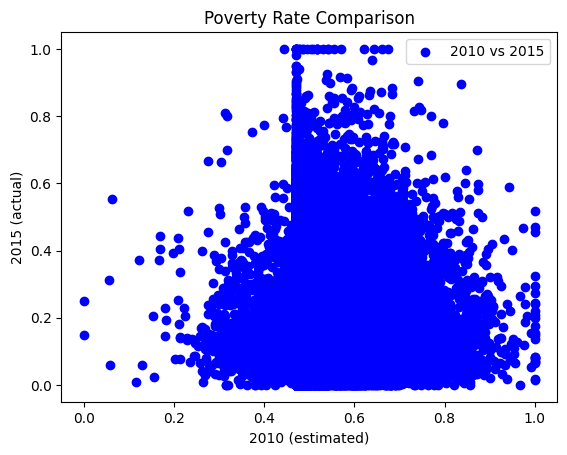

In [105]:
plt.scatter(final_atlas_ten['PovertyRate'], final_atlas_fifteen['PovertyRate'], c='blue', label='2010 vs 2015')
plt.xlabel('2010 (estimated)')
plt.ylabel('2015 (actual)')
plt.title('Poverty Rate Comparison')
plt.legend()
plt.show()

### Saving our 2015 & 2010 data

In [ ]:
processed_atlas_ten.to_csv('../data/processed/processed_ten.csv')
processed_atlas_fifteen.to_csv('../data/processed/processed_atlas_fifteen.csv')

In [109]:
final_atlas_nineteen = pd.DataFrame(scaled_processed_atlas_nineteen, columns=processed_atlas_nineteen.columns)
final_atlas_nineteen.head()

,CensusTract,Urban,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractHUNV,TractSNAP,lapop1share,lalowi1share,lakids1share,laseniors1share,lahunv1share,lasnap1share,lalowi10share,lalowi20share,Pop2010,LOWIRatio,SNAPRatio,HUNVRatio,FoodInsecurityIndex,SNAPDisparity,LOWIWeighted
0,0.000000e+00,1.0,0.113,0.318183,0.036220,0.042803,0.012796,0.000990,0.046897,0.9919,0.2411,0.289978,0.1144,0.0079,0.1322,0.02935,0.007251,0.051027,0.007051,0.022840,0.000292,0.008725,0.849223,0.006762
1,1.816698e-09,1.0,0.179,0.187881,0.063843,0.051161,0.012391,0.014689,0.071724,0.5811,0.2783,0.205837,0.0583,0.0900,0.1295,0.02935,0.007251,0.057916,0.010951,0.030778,0.003815,0.014296,0.852045,0.018882
2,3.633395e-09,1.0,0.150,0.242867,0.103964,0.075475,0.025418,0.016339,0.079080,0.4600,0.1418,0.135903,0.0596,0.0000,0.0587,0.02935,0.007251,0.090038,0.011472,0.021832,0.002730,0.013853,0.921084,0.025766
3,5.450093e-09,1.0,0.028,0.275182,0.073396,0.085690,0.052342,0.003466,0.045057,0.3109,0.0783,0.086894,0.0539,0.0046,0.0176,0.02935,0.007251,0.117086,0.006229,0.009566,0.000445,0.007032,0.961000,0.003395
4,7.266791e-09,1.0,0.152,0.379128,0.178475,0.266948,0.065196,0.037960,0.155862,0.2455,0.0545,0.073128,0.0336,0.0135,0.0204,0.02935,0.007251,0.287442,0.006170,0.013481,0.001987,0.007736,0.958351,0.044822


In [110]:
final_atlas_nineteen.to_csv('../data/raw/atlas_2019_data')